## Fruit Classification Using Computer Vision: A Study with the Fruits-360 Dataset

**Goal: This notebook will be used to train a CV model on the Fruits-360 dataset to classify different types of fruits based on images and export the model into your directory**

### Roadmap

1) Follow steps in README.md

2) Preprocess images from dataset

3) Train CNN Model with a optimizer and loss function. 

4) Evaluate Performance 

5) Save trained model for deployement used for inference in your app!

7) Use results and Nutrients API to get nutrtion into your user profile in your app! (Part 2 of project)

In [23]:
import torch
import os
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

## Step 2 - Preprocess images

In [33]:
class FruitsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.label_to_index = {}  # Map labels to indices

        # Load image paths and labels
        for idx, label in enumerate(os.listdir(root_dir)):
            label_dir = os.path.join(root_dir, label)
            if os.path.isdir(label_dir):
                self.label_to_index[label] = idx  # Assign an index to each label
                for image_name in os.listdir(label_dir):
                    self.image_paths.append(os.path.join(label_dir, image_name))
                    self.labels.append(idx)  # Store the index instead of the label

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label)  # Convert label to a tensor

# Define transformations
transform = transforms.Compose([
    transforms.Resize((100, 100)),  # Resize images to 100x100
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Create dataset and dataloader
dataset = FruitsDataset(root_dir='/Users/maryjojohnson/Documents/mdst-w24/fruits-360_dataset_100x100/fruits-360/Training', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


## Step 3 - Train CNN model 

In [14]:

# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(32 * 25 * 25, 128)  # Adjust based on image size
        self.fc2 = nn.Linear(128, len(set(dataset.labels)))  # Adjust based on number of classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 25 * 25)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in dataloader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}')

print('Finished Training')

Epoch [1/10], Loss: 0.2917
Epoch [2/10], Loss: 0.0432
Epoch [3/10], Loss: 0.0236
Epoch [4/10], Loss: 0.0195
Epoch [5/10], Loss: 0.0150
Epoch [6/10], Loss: 0.0103
Epoch [7/10], Loss: 0.0154
Epoch [8/10], Loss: 0.0129
Epoch [9/10], Loss: 0.0104
Epoch [10/10], Loss: 0.0169
Finished Training


## Step 4: Evaluate Performance

In [17]:

# Assuming you have a test dataset directory similar to the training dataset
test_dataset = FruitsDataset(root_dir='/Users/maryjojohnson/Documents/mdst-w24/fruits-360_dataset_100x100/fruits-360/Test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Function to evaluate the model
def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in dataloader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)  # Get the index of the max log-probability
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    # Calculate precision, recall, and F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

# Evaluate the model
evaluate_model(model, test_loader)

Accuracy: 0.9555
Precision: 0.9610
Recall: 0.9555
F1 Score: 0.9544


## Step 5: Save Trained model 

In [18]:
# Save the model's state dictionary
torch.save(model.state_dict(), 'simple_cnn_model.pth')

## Step 6: (Optional) - Test the model on real images

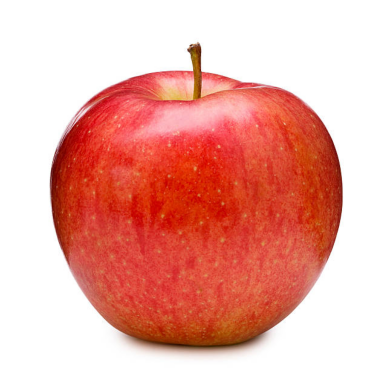

In [21]:
import matplotlib.pyplot as plt

#Print image
# Load the image
image_path = 'Apple_image.img'  # Replace with your image path
image = Image.open(image_path)

# Display the image
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()

In [34]:
import torch
from torchvision import transforms
from PIL import Image
import os
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(32 * 25 * 25, 128)  # Adjust based on image size
        self.fc2 = nn.Linear(128, len(set(dataset.labels)))  # Adjust based on number of classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 25 * 25)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Load the trained model
model = SimpleCNN()
model.load_state_dict(torch.load('simple_cnn_model.pth'))
model.eval()  # Set the model to evaluation mode

# Define the same transformations used during training
transform = transforms.Compose([
    transforms.Resize((100, 100)),  # Resize images to 100x100
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

def predict_image(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension

    # Make prediction
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    return predicted.item()

# Test the classifier on a real image
image_path = 'Apple_image.img'  # Replace with the path to your image
predicted_label_index = predict_image(image_path)

# Map the predicted index back to the label
index_to_label = {v: k for k, v in dataset.label_to_index.items()}
predicted_label = index_to_label[predicted_label_index]

print(f'The predicted label for the image is: {predicted_label}')

The predicted label for the image is: Pear Red 1


/var/folders/g9/pqkgwf2s703_g5bd061tpf700000gn/T/ipykernel_40074/809077067.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('simple_cnn_

## Part 7 (Optional) Example API usage

In [8]:
import requests
import os
from dotenv import load_dotenv
import pandas as pd
# Load environment variables from .env file
load_dotenv()

# Access the variables
app_id = os.getenv('EDAMAM_APP_ID')
app_key = os.getenv('EDAMAM_APP_KEY')

def analyze_ingredient(ingredient):
    # Edamam API endpoint for ingredient analysis
    api_url = "https://api.edamam.com/api/nutrition-data"
    
    # Parameters for the GET request
    params = {
        'app_id': app_id,
        'app_key': app_key,
        'ingr': ingredient
    }
    
    # Make the GET request
    response = requests.get(api_url, params=params)
    
    # Check if the request was successful
    if response.status_code == 200:
        data = response.json()
        if not data.get('totalNurtients'):
            print(f"Failed to analyze ingredient: {ingredient}")
            return None
        
        return data
    else:
        print(f"Failed to analyze ingredient: {response.status_code}")
        return None

# Example usage
#** REPLACE INGREDIENT WITH PREDICTED LABEL/MAKE SURE TO INCLUDE QUANTITY + RIGHT FORMAT **
ingredient = "huckleberry 1"
ingredient_info = analyze_ingredient(ingredient)
# Extract total nutrients into a DataFrame
nutrients = ingredient_info.get('totalNutrients', {})
nutrients_data = {
    nutrient: {
        'label': details['label'],
        'quantity': details['quantity'],
        'unit': details['unit']
    }
    for nutrient, details in nutrients.items()
}

# Convert to DataFrame
df = pd.DataFrame.from_dict(nutrients_data, orient='index')

# Display the DataFrame
df

Failed to analyze ingredient: huckleberry 1


AttributeError: 'NoneType' object has no attribute 'get'